# Disaster Tweets

## Imports

In [1]:
!python -m spacy download en_core_web_md -q

2022-09-17 14:29:48.306216: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
     |████████████████████████████████| 42.8 MB 44.2 MB/s 
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_md')


In [2]:
import tensorflow as tf 
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.metrics import BinaryAccuracy
from tensorflow.keras.layers import Dense, Embedding, GlobalAveragePooling1D, GRU, LSTM
from tensorflow import keras

import pathlib 
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import os
import io
import warnings
from sklearn.model_selection import train_test_split
warnings.filterwarnings('ignore')

# Import Spacy and english initialisation
import en_core_web_md
# Import Stop words 
from spacy.lang.en.stop_words import STOP_WORDS

In [3]:
nlp = en_core_web_md.load()

In [4]:
data = pd.read_csv('src/train.csv')

In [5]:
data.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


## Preprocessing

### Text cleaning on train

In [6]:
data["text_clean"] = data["text"].apply(lambda x:''.join(ch for ch in x if ch.isalnum() or ch==" " or ch=="'"))
data["text_clean"] = data["text_clean"].apply(lambda x: x.replace(" +"," ").lower().strip())
data["text_clean"] = data["text_clean"].apply(lambda x: " ".join([token.lemma_ for token in nlp(x) if (token.lemma_ not in STOP_WORDS) and (token.text not in STOP_WORDS)]))

data

,id,keyword,location,text,target,text_clean
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1,deed reason earthquake allah forgive
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,forest fire near la ronge sask canada
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1,resident ask ' shelter place ' notify officer ...
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1,13000 people receive wildfire evacuation order...
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1,got send photo ruby alaska smoke wildfire pour...
...,...,...,...,...,...,...
7608,10869,NaN,NaN,Two giant cranes holding a bridge collapse int...,1,giant crane hold bridge collapse nearby home h...
7609,10870,NaN,NaN,@aria_ahrary @TheTawniest The out of control w...,1,ariaahrary thetawniest control wild fire calif...
7610,10871,NaN,NaN,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...,1,m194 0104 utc5 km s volcano hawaii httptcozdto...
7611,10872,NaN,NaN,Police investigating after an e-bike collided ...,1,police investigate ebike collide car little po...


### Encoding text

In [7]:
tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=3500) # instanciate the tokenizer
tokenizer.fit_on_texts(data.text_clean)
data["text_encoded"] = tokenizer.texts_to_sequences(data.text_clean)

In [8]:
data.head()

,id,keyword,location,text,target,text_clean,text_encoded
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1,deed reason earthquake allah forgive,"[414, 171, 1376, 1703]"
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,forest fire near la ronge sask canada,"[118, 3, 165, 509, 953]"
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1,resident ask ' shelter place ' notify officer ...,"[1377, 446, 1, 1704, 323, 1, 291, 185, 1704, 3..."
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1,13000 people receive wildfire evacuation order...,"[2305, 6, 2306, 67, 185, 356, 33]"
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1,got send photo ruby alaska smoke wildfire pour...,"[268, 177, 122, 1517, 172, 67, 2307, 109]"


### Padding text

In [9]:
text_pad = tf.keras.preprocessing.sequence.pad_sequences(data.text_encoded, padding="post")

In [10]:
text_pad.shape

(7613, 21)

### Train and validation split

In [11]:
x_train, x_val, y_train, y_val = train_test_split(text_pad,data.target, test_size=0.3, random_state=42)

In [12]:
train = tf.data.Dataset.from_tensor_slices((x_train, y_train))
val = tf.data.Dataset.from_tensor_slices((x_val, y_val))

In [13]:
train_batch = train.shuffle(len(train)).batch(512)
val_batch = val.shuffle(len(val)).batch(512)

## Model with embedding

In [14]:
print(tokenizer.num_words)

3500


In [15]:
vocab_size = tokenizer.num_words
embedding_dim=8

### Model

In [16]:
emb_model = Sequential([
  Embedding(vocab_size+1, embedding_dim, name="embedding"), # the embedding layer
  # the input dim needs to be equal to the size of the vocabulary + 1 (because of
  # the zero padding)
  GlobalAveragePooling1D(), # this will pick the average for every word in the sentence
  # along each dimension of the representation space.
  Dense(16, activation='relu'), # a dense layer
  Dense(1, activation="sigmoid") # the prediction layer
])

emb_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 8)           28008     
                                                                 
 global_average_pooling1d (G  (None, 8)                0         
 lobalAveragePooling1D)                                          
                                                                 
 dense (Dense)               (None, 16)                144       
                                                                 
 dense_1 (Dense)             (None, 1)                 17        
                                                                 
Total params: 28,169
Trainable params: 28,169
Non-trainable params: 0
_________________________________________________________________


In [17]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir="logs")

### Compile

In [18]:
optimizer= tf.keras.optimizers.Adam()

emb_model.compile(optimizer=optimizer,
              loss=BinaryCrossentropy(),
              metrics=[BinaryAccuracy()])

### Fit on 40 epochs

In [19]:
history_emb = emb_model.fit(
    train_batch,
    validation_data=val_batch,
    epochs=40,
    callbacks=[tensorboard_callback])

Epoch 1/40
11/11 [==============================] - 1s 18ms/step - loss: 0.6913 - binary_accuracy: 0.5504 - val_loss: 0.6883 - val_binary_accuracy: 0.5771
Epoch 2/40
11/11 [==============================] - 0s 7ms/step - loss: 0.6878 - binary_accuracy: 0.5675 - val_loss: 0.6852 - val_binary_accuracy: 0.5771
Epoch 3/40
11/11 [==============================] - 0s 5ms/step - loss: 0.6848 - binary_accuracy: 0.5675 - val_loss: 0.6821 - val_binary_accuracy: 0.5771
Epoch 4/40
11/11 [==============================] - 0s 5ms/step - loss: 0.6818 - binary_accuracy: 0.5675 - val_loss: 0.6790 - val_binary_accuracy: 0.5771
Epoch 5/40
11/11 [==============================] - 0s 8ms/step - loss: 0.6788 - binary_accuracy: 0.5675 - val_loss: 0.6761 - val_binary_accuracy: 0.5771
Epoch 6/40
11/11 [==============================] - 0s 5ms/step - loss: 0.6761 - binary_accuracy: 0.5675 - val_loss: 0.6730 - val_binary_accuracy: 0.5771
Epoch 7/40
11/11 [==============================] - 0s 10ms/step - loss: 0.

### Perfomrance visualization 

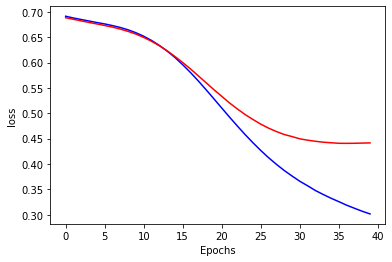

In [20]:
# Visualization of the training process on the loss function 
plt.plot(history_emb.history["loss"], color="b")
plt.plot(history_emb.history["val_loss"], color="r")
plt.ylabel("loss")
plt.xlabel("Epochs")
plt.show()

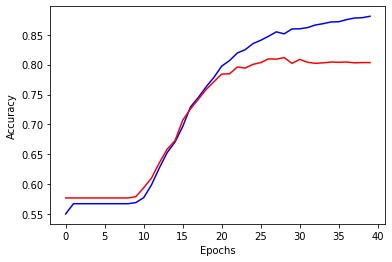

In [21]:
# Visualization of accuracy training 
plt.plot(history_emb.history["binary_accuracy"], color="b")
plt.plot(history_emb.history["val_binary_accuracy"], color="r")
plt.ylabel("Accuracy")
plt.xlabel("Epochs")
plt.show()

* Good perfomances

## Model with GRU

### Model

In [22]:
gru_model = Sequential([
  Embedding(vocab_size, embedding_dim, name="embedding"), # the embedding layer
  # the input dim needs to be equal to the size of the vocabulary + 1 (because of
  # the zero padding)
  GRU(units=64, return_sequences=True), # maintains the sequential nature
  GRU(units=32, return_sequences=False), # returns the last output
  Dense(16, activation='relu'), # a dense layer
  Dense(1, activation="sigmoid") # the prediction layer
])

gru_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 8)           28000     
                                                                 
 gru (GRU)                   (None, None, 64)          14208     
                                                                 
 gru_1 (GRU)                 (None, 32)                9408      
                                                                 
 dense_2 (Dense)             (None, 16)                528       
                                                                 
 dense_3 (Dense)             (None, 1)                 17        
                                                                 
Total params: 52,161
Trainable params: 52,161
Non-trainable params: 0
_________________________________________________________________


### Compile

In [23]:
gru_model.compile(optimizer=optimizer,
              loss=BinaryCrossentropy(),
              metrics=[BinaryAccuracy()])

### Fit on 10 epochs

In [24]:
history_gru = gru_model.fit(
    train_batch,
    validation_data=val_batch,
    epochs=10,
    callbacks=[tensorboard_callback])

Epoch 1/10
11/11 [==============================] - 5s 183ms/step - loss: 0.6884 - binary_accuracy: 0.5521 - val_loss: 0.6818 - val_binary_accuracy: 0.5771
Epoch 2/10
11/11 [==============================] - 1s 81ms/step - loss: 0.6842 - binary_accuracy: 0.5675 - val_loss: 0.6812 - val_binary_accuracy: 0.5771
Epoch 3/10
11/11 [==============================] - 1s 83ms/step - loss: 0.6826 - binary_accuracy: 0.5675 - val_loss: 0.6728 - val_binary_accuracy: 0.5771
Epoch 4/10
11/11 [==============================] - 1s 80ms/step - loss: 0.5907 - binary_accuracy: 0.6906 - val_loss: 0.5451 - val_binary_accuracy: 0.7391
Epoch 5/10
11/11 [==============================] - 1s 83ms/step - loss: 0.4435 - binary_accuracy: 0.8174 - val_loss: 0.4614 - val_binary_accuracy: 0.7995
Epoch 6/10
11/11 [==============================] - 1s 84ms/step - loss: 0.3658 - binary_accuracy: 0.8623 - val_loss: 0.4765 - val_binary_accuracy: 0.7986
Epoch 7/10
11/11 [==============================] - 1s 79ms/step - lo

### Performance visualization

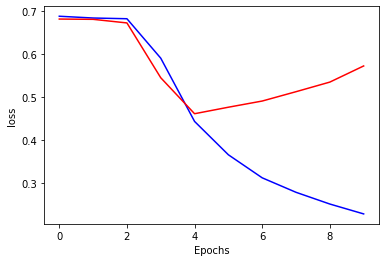

In [25]:
# Visualization of the training process on the loss function 
plt.plot(history_gru.history["loss"], color="b")
plt.plot(history_gru.history["val_loss"], color="r")
plt.ylabel("loss")
plt.xlabel("Epochs")
plt.show()

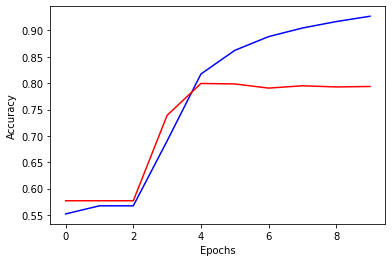

In [26]:
# Visualization of accuracy training 
plt.plot(history_gru.history["binary_accuracy"], color="b")
plt.plot(history_gru.history["val_binary_accuracy"], color="r")
plt.ylabel("Accuracy")
plt.xlabel("Epochs")
plt.show()

* The model tends to quickly overfit and have worst performances

## Model with LSTM

### Model

In [27]:
lstm_model = Sequential([
  Embedding(vocab_size, embedding_dim, name="embedding"), # the embedding layer
  # the input dim needs to be equal to the size of the vocabulary + 1 (because of
  # the zero padding)
  LSTM(units=64, return_sequences=True), # maintains the sequential nature
  LSTM(units=32, return_sequences=False), # returns the last output
  Dense(16, activation='relu'), # a dense layer
  Dense(1, activation="sigmoid") # the prediction layer
])

lstm_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 8)           28000     
                                                                 
 lstm (LSTM)                 (None, None, 64)          18688     
                                                                 
 lstm_1 (LSTM)               (None, 32)                12416     
                                                                 
 dense_4 (Dense)             (None, 16)                528       
                                                                 
 dense_5 (Dense)             (None, 1)                 17        
                                                                 
Total params: 59,649
Trainable params: 59,649
Non-trainable params: 0
_________________________________________________________________


### Compile

In [28]:
lstm_model.compile(optimizer=optimizer,
              loss=BinaryCrossentropy(),
              metrics=[BinaryAccuracy()])

### Fit on 10 epochs

In [29]:
history_lstm = lstm_model.fit(
    train_batch,
    validation_data=val_batch,
    epochs=10,
    callbacks=[tensorboard_callback])

Epoch 1/10
11/11 [==============================] - 6s 172ms/step - loss: 0.6858 - binary_accuracy: 0.5523 - val_loss: 0.6792 - val_binary_accuracy: 0.5771
Epoch 2/10
11/11 [==============================] - 1s 98ms/step - loss: 0.5890 - binary_accuracy: 0.6799 - val_loss: 0.5280 - val_binary_accuracy: 0.7894
Epoch 3/10
11/11 [==============================] - 1s 96ms/step - loss: 0.4011 - binary_accuracy: 0.8495 - val_loss: 0.4684 - val_binary_accuracy: 0.7863
Epoch 4/10
11/11 [==============================] - 1s 97ms/step - loss: 0.3210 - binary_accuracy: 0.8882 - val_loss: 0.4696 - val_binary_accuracy: 0.7881
Epoch 5/10
11/11 [==============================] - 1s 110ms/step - loss: 0.2777 - binary_accuracy: 0.9067 - val_loss: 0.5725 - val_binary_accuracy: 0.7666
Epoch 6/10
11/11 [==============================] - 1s 114ms/step - loss: 0.2412 - binary_accuracy: 0.9195 - val_loss: 0.5994 - val_binary_accuracy: 0.7780
Epoch 7/10
11/11 [==============================] - 1s 92ms/step - 

### Performance visualization

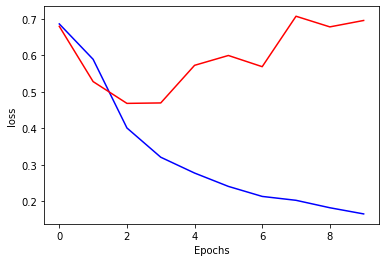

In [30]:
# Visualization of the training process on the loss function 
plt.plot(history_lstm.history["loss"], color="b")
plt.plot(history_lstm.history["val_loss"], color="r")
plt.ylabel("loss")
plt.xlabel("Epochs")
plt.show()

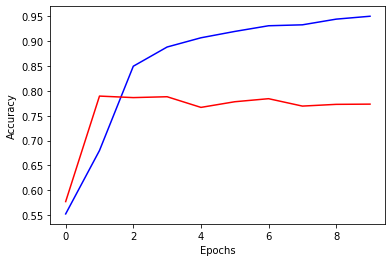

In [31]:
# Visualization of accuracy training 
plt.plot(history_lstm.history["binary_accuracy"], color="b")
plt.plot(history_lstm.history["val_binary_accuracy"], color="r")
plt.ylabel("Accuracy")
plt.xlabel("Epochs")
plt.show()

* Same conclusion as the GRU model

## GRU with learning rate tuned

**Let's try to fight overfitting with tuning the learning rate**

### Model

In [32]:
gru_lr_model = Sequential([
  Embedding(vocab_size, embedding_dim, name="embedding"), # the embedding layer
  # the input dim needs to be equal to the size of the vocabulary + 1 (because of
  # the zero padding)
  GRU(units=64, return_sequences=True), # maintains the sequential nature
  GRU(units=32, return_sequences=False), # returns the last output
  Dense(16, activation='relu'), # a dense layer
  Dense(1, activation="sigmoid") # the prediction layer
])

gru_lr_model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 8)           28000     
                                                                 
 gru_2 (GRU)                 (None, None, 64)          14208     
                                                                 
 gru_3 (GRU)                 (None, 32)                9408      
                                                                 
 dense_6 (Dense)             (None, 16)                528       
                                                                 
 dense_7 (Dense)             (None, 1)                 17        
                                                                 
Total params: 52,161
Trainable params: 52,161
Non-trainable params: 0
_________________________________________________________________


### Compile

In [33]:
optimizer= tf.keras.optimizers.Adam(learning_rate=0.0001)

gru_lr_model.compile(optimizer=optimizer,
              loss=BinaryCrossentropy(),
              metrics=[BinaryAccuracy()])

### Fit on 40 epochs

In [34]:
history_gru_lr = gru_lr_model.fit(
    train_batch,
    validation_data=val_batch,
    epochs=40,
    callbacks=[tensorboard_callback])

Epoch 1/40
11/11 [==============================] - 5s 195ms/step - loss: 0.6930 - binary_accuracy: 0.5442 - val_loss: 0.6925 - val_binary_accuracy: 0.5771
Epoch 2/40
11/11 [==============================] - 1s 84ms/step - loss: 0.6922 - binary_accuracy: 0.5675 - val_loss: 0.6912 - val_binary_accuracy: 0.5771
Epoch 3/40
11/11 [==============================] - 1s 82ms/step - loss: 0.6908 - binary_accuracy: 0.5675 - val_loss: 0.6894 - val_binary_accuracy: 0.5771
Epoch 4/40
11/11 [==============================] - 1s 80ms/step - loss: 0.6893 - binary_accuracy: 0.5675 - val_loss: 0.6875 - val_binary_accuracy: 0.5771
Epoch 5/40
11/11 [==============================] - 1s 81ms/step - loss: 0.6877 - binary_accuracy: 0.5675 - val_loss: 0.6859 - val_binary_accuracy: 0.5771
Epoch 6/40
11/11 [==============================] - 1s 81ms/step - loss: 0.6864 - binary_accuracy: 0.5675 - val_loss: 0.6845 - val_binary_accuracy: 0.5771
Epoch 7/40
11/11 [==============================] - 1s 81ms/step - lo

### Performance visualization

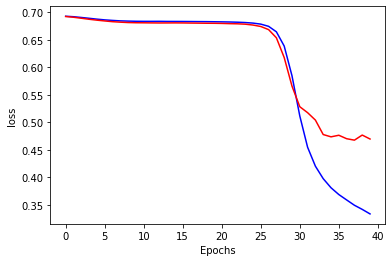

In [35]:
# Visualization of the training process on the loss function 
plt.plot(history_gru_lr.history["loss"], color="b")
plt.plot(history_gru_lr.history["val_loss"], color="r")
plt.ylabel("loss")
plt.xlabel("Epochs")
plt.show()

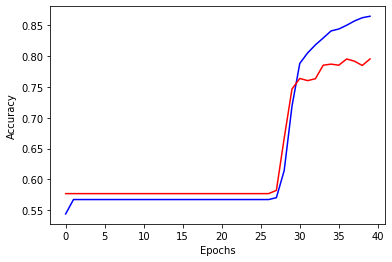

In [36]:
# Visualization of accuracy training 
plt.plot(history_gru_lr.history["binary_accuracy"], color="b")
plt.plot(history_gru_lr.history["val_binary_accuracy"], color="r")
plt.ylabel("Accuracy")
plt.xlabel("Epochs")
plt.show()

* Has equivalent performances as the simple embedding model

## GRU simplified

**Let's try to fight overfitting by simplifying the models**

### Model

In [37]:
gru_s_model = Sequential([
  Embedding(vocab_size, embedding_dim, name="embedding"), # the embedding layer
  # the input dim needs to be equal to the size of the vocabulary + 1 (because of
  # the zero padding)
  GRU(units=32, return_sequences=False), # returns the last output
  Dense(16, activation='relu'), # a dense layer
  Dense(1, activation="sigmoid") # the prediction layer
])

gru_s_model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 8)           28000     
                                                                 
 gru_4 (GRU)                 (None, 32)                4032      
                                                                 
 dense_8 (Dense)             (None, 16)                528       
                                                                 
 dense_9 (Dense)             (None, 1)                 17        
                                                                 
Total params: 32,577
Trainable params: 32,577
Non-trainable params: 0
_________________________________________________________________


### Compile

In [38]:
optimizer= tf.keras.optimizers.Adam()

gru_s_model.compile(optimizer=optimizer,
              loss=BinaryCrossentropy(),
              metrics=[BinaryAccuracy()])

### Fit on 15 epochs

In [39]:
history_gru_s = gru_s_model.fit(
    train_batch,
    validation_data=val_batch,
    epochs=15,
    callbacks=[tensorboard_callback])

Epoch 1/15
11/11 [==============================] - 3s 68ms/step - loss: 0.6900 - binary_accuracy: 0.5675 - val_loss: 0.6862 - val_binary_accuracy: 0.5771
Epoch 2/15
11/11 [==============================] - 0s 24ms/step - loss: 0.6854 - binary_accuracy: 0.5675 - val_loss: 0.6818 - val_binary_accuracy: 0.5771
Epoch 3/15
11/11 [==============================] - 0s 29ms/step - loss: 0.6852 - binary_accuracy: 0.5675 - val_loss: 0.6812 - val_binary_accuracy: 0.5771
Epoch 4/15
11/11 [==============================] - 0s 29ms/step - loss: 0.6841 - binary_accuracy: 0.5675 - val_loss: 0.6815 - val_binary_accuracy: 0.5771
Epoch 5/15
11/11 [==============================] - 0s 27ms/step - loss: 0.6840 - binary_accuracy: 0.5675 - val_loss: 0.6815 - val_binary_accuracy: 0.5771
Epoch 6/15
11/11 [==============================] - 0s 24ms/step - loss: 0.6839 - binary_accuracy: 0.5675 - val_loss: 0.6814 - val_binary_accuracy: 0.5771
Epoch 7/15
11/11 [==============================] - 0s 27ms/step - los

### Performance visualization

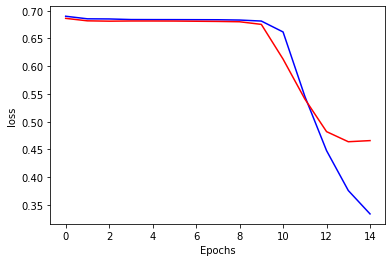

In [40]:
# Visualization of the training process on the loss function 
plt.plot(history_gru_s.history["loss"], color="b")
plt.plot(history_gru_s.history["val_loss"], color="r")
plt.ylabel("loss")
plt.xlabel("Epochs")
plt.show()

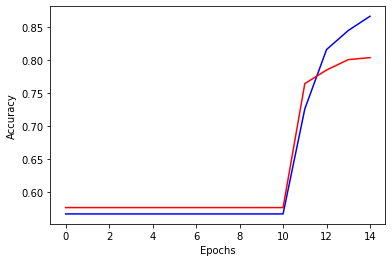

In [41]:
# Visualization of accuracy training 
plt.plot(history_gru_s.history["binary_accuracy"], color="b")
plt.plot(history_gru_s.history["val_binary_accuracy"], color="r")
plt.ylabel("Accuracy")
plt.xlabel("Epochs")
plt.show()

## LSTM simplified

**Let's try to fight overfitting by simplifying the models**

### Model

In [42]:
lstm_s_model = Sequential([
  Embedding(vocab_size, embedding_dim, name="embedding"), # the embedding layer
  # the input dim needs to be equal to the size of the vocabulary + 1 (because of
  # the zero padding)
  LSTM(units=32, return_sequences=False), # returns the last output
  Dense(16, activation='relu'), # a dense layer
  Dense(1, activation="sigmoid") # the prediction layer
])

lstm_s_model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 8)           28000     
                                                                 
 lstm_2 (LSTM)               (None, 32)                5248      
                                                                 
 dense_10 (Dense)            (None, 16)                528       
                                                                 
 dense_11 (Dense)            (None, 1)                 17        
                                                                 
Total params: 33,793
Trainable params: 33,793
Non-trainable params: 0
_________________________________________________________________


### Compile

In [43]:
lstm_s_model.compile(optimizer=optimizer,
              loss=BinaryCrossentropy(),
              metrics=[BinaryAccuracy()])

### Fit on 10 epochs

In [44]:
history_lstm_s = lstm_s_model.fit(
    train_batch,
    validation_data=val_batch,
    epochs=10,
    callbacks=[tensorboard_callback])

Epoch 1/10
11/11 [==============================] - 2s 74ms/step - loss: 0.6885 - binary_accuracy: 0.5573 - val_loss: 0.6783 - val_binary_accuracy: 0.5771
Epoch 2/10
11/11 [==============================] - 0s 30ms/step - loss: 0.6760 - binary_accuracy: 0.5675 - val_loss: 0.6484 - val_binary_accuracy: 0.5771
Epoch 3/10
11/11 [==============================] - 0s 30ms/step - loss: 0.5684 - binary_accuracy: 0.7014 - val_loss: 0.5471 - val_binary_accuracy: 0.7395
Epoch 4/10
11/11 [==============================] - 0s 31ms/step - loss: 0.4393 - binary_accuracy: 0.8259 - val_loss: 0.4931 - val_binary_accuracy: 0.7785
Epoch 5/10
11/11 [==============================] - 0s 33ms/step - loss: 0.3483 - binary_accuracy: 0.8668 - val_loss: 0.4869 - val_binary_accuracy: 0.7833
Epoch 6/10
11/11 [==============================] - 0s 30ms/step - loss: 0.2950 - binary_accuracy: 0.8934 - val_loss: 0.5282 - val_binary_accuracy: 0.7881
Epoch 7/10
11/11 [==============================] - 0s 31ms/step - los

### Performance visualization

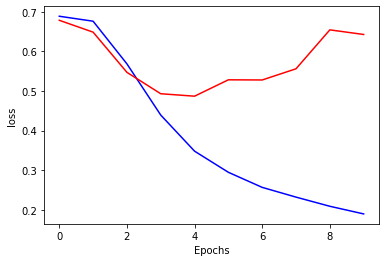

In [45]:
# Visualization of the training process on the loss function 
plt.plot(history_lstm_s.history["loss"], color="b")
plt.plot(history_lstm_s.history["val_loss"], color="r")
plt.ylabel("loss")
plt.xlabel("Epochs")
plt.show()

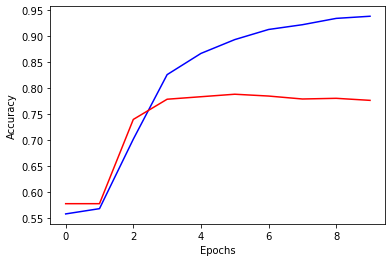

In [46]:
# Visualization of accuracy training 
plt.plot(history_lstm_s.history["binary_accuracy"], color="b")
plt.plot(history_lstm_s.history["val_binary_accuracy"], color="r")
plt.ylabel("Accuracy")
plt.xlabel("Epochs")
plt.show()

## Conclusion

* Our best models (simple ebmbedding,GRU with lower learning rate, and GRU simplified) have equivalent performances

* around 30% loss and 85% accuracy on train

* around 45% loss and 80% accuracy on validation

* It's best to use the simple embedding model